# Prediction of Renewable Power Loss caused by Feed-in Management Events

The goal of this project is a model that predicts lost power for the next control interval(s) in dependence of various parameters in the past. This is useful for energy traders, grid operators as well as consumers who participate in Demand-Side-Managment. In the present notebook test and validation metrics of the various models are shown and compared. A selection of the best performing model will end this project. 

**Business Context: keeping the energy grid stable**<br>
In recent years the expansion of renewable generation capacity has been proceeding due to efforts being made to transition to low carbon energy systems. This development causes a variety of challenges including the intermittent availability of renewable generation, such as wind energy, as well as the need for construction of according transmission infrastructure. The resulting mismatch between transmission and generation infrastructure causes congestion in the transmission grid. Germanys electricity market relies on feed-in managment to cure short-time congestion when grids cannot absorb all intermittent generation. The term feed-in management refers to the curtailment of power that is fed into the power grid in dependence of the power that is actually used by connected consumers or is being transferred on to other grid areas. A prediction of Feed-In Management Orders could aid with Demand Side Mangement Scheduling, making use of the otherwise lost renewable energy. 


<img src="./figures/overview_DMS_FIM.png" alt="grid_areas_germany" width="600" />



### Project Organisation

The project is organized as seen below: 

- [FeedInMngmt_presentation.pdf](FeedInMngmt_presentation.pdf): Presentation of the project including additional explanation about the feed-in managment sitatuion. (to be uploaded)
- [FeedInMngmt_EDA.ipynb](FeedInMngmt_EDA.ipynb): Loading and pre-processing feed-in managment data as well as weather data, price data and energy consumption data. Followed by an exploration of the given data as well as an investigation of correlating behavior of various time series (e.g., the influence of wind on feed in management events). This document ends with a ranking and selection of features by their importance.  
- [FeedInMngmt_Base_Models.ipynb](FeedInMngmt_Base_Models.ipynb): Creation and elaboration of train-validation-test split as well as design of two naive baseline models: the Shift model (e.g., the next timestep equals the last time step) and an  Exponential Smoothing model (e.g., next timestep equals the moving average over the last X hours). In addition, functions to evaluate the test results are described in this document.  
- [FeedInMngmt_Prophet.ipynb](FeedInMngmt_Prophet.ipynb): Implementation and evaluation of a FB Prophet Model for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_LSTM_NN.ipynb](FeedInMngmt_LSTM_NN.ipynb): Implementation and evaluation of a Long-Short-Term-Memory Recurrent Neural Network for the prediction of one timestep and multiple timesteps into the future. 
- [FeedInMngmt_Results.ipynb](FeedInMngmt_Results.ipynb): Evaluation of the different models based on the chosen test metrics.

# Environment Set-Up

In [2]:
reset -fs

In [3]:
# Importing the most important modules and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
import pickle

# For Data Mining and data export
import glob

## Global Variables and Settings

In [4]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

color_1 = 'goldenrod'
color_2 = 'darkred'

## Definition of Function

In [5]:
def split_at(string, seperator, at_n, return_after=True):
    '''
    helper function to sperate file path into name
    '''
    words = string.split(seperator)
    if return_after: 
        return seperator.join(words[at_n:])
    else: 
        return seperator.join(words[:at_n])

def clean_brackets(df_result): 
    '''
    Explaination: Working with LSTMs, the error metrics are sometimes encapsulated into square brackets. 
    Return: dataframe without square brackets. 
    '''
    for colm in df_result.columns: 
        if df_result[colm].dtype != np.number:
            df_result[colm] = [float(x.replace("[", "").replace("]", "")) for x in df_result[colm]]
    return df_result

In [6]:
def get_erros(metric = 'MAPE', folder='Test Errors'):
    '''
    Reason: Error Metrics are saved into .csv files, one file per model including multiple error metrics
    metric: ['RMSE', 'R2', 'MAE', 'MAPE']
    folder: ['Test Errors', 'Validation Errors']
    Return: pd.DataFrame with specified Error Metric for all .csvs in specified folder
    '''
    file_start = '_'.join(folder.split(' ')).lower()
    errors = pd.DataFrame()
    for file in glob.glob(f'{folder}/{file_start}*.csv'): 
        # Preperation of column Name
        name = file
        name = split_at(file, '_', 2, return_after=True)
        name = split_at(name, '.', 1, return_after=False)
        name = name.replace('_', ' ')
        
        #loading raw data
        raw_table = pd.read_csv(file, header=0, usecols=[metric])
        
        #concatenate data to the right 
        raw_table.rename(columns={metric:name}, inplace=True)
        raw_table.index += 1
        errors = pd.concat([errors, raw_table], axis=1, ignore_index = False)
    errors.index.name = 'Step'
    errors = clean_brackets(errors)
    return errors.T

In [7]:
def plot_results(df_results, metric='MAPE', val_or_test='Test'): 
    df_results = df_results.T
    ###### COLOR SETTINGS ##### evenly_spaced_colors for len(colm)
    colors=['olive', 'goldenrod', 'darkred', 'grey', 'b','g','r','c','m','y'] #'sandybrown', 'sienna'
    if df_results.shape[1] > len(colors): 
        evenly_spaced_interval = np.linspace(0, 1, len(df_results.columns))
        colors = [cm.jet(x) for x in evenly_spaced_interval]
    ###### DATA PLOTTING ###### 
    fig, ax = plt.subplots(figsize=(20,14))               
    for colm, c in zip(df_results.columns, colors):
        plt.plot(df_results[colm], label=colm ,color=c, lw=4)

        
    ###### PLOT SETTINGS #######
    plt.title(f'{metric} for each predicted timestep into the future ({val_or_test} set)', fontsize=20)
    plt.xlabel('STEPS INTO THE FUTURE', fontsize=14)
    plt.ylabel(f'{metric}', fontsize=14)
    plt.xlim(1, 19)
    plt.legend(loc='upper left', fontsize=14,  bbox_to_anchor=(1.01, 1))

    ###### OUTPUT #######
    plt.savefig(f'figures/results_{metric}_{val_or_test}.png', bbox_inches='tight', transparent=True)
    plt.show;

# Results

## MAPE Test Data

Step,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
multivariate lstmNN,0.36,0.37,0.41,0.45,0.48,0.44,0.47,0.53,0.46,0.49,0.53,0.62,0.51,0.52,0.50,0.55,0.55,0.60
fbprophet,0.11,0.15,0.19,0.22,0.25,0.28,0.31,0.35,0.37,0.40,0.42,0.44,0.46,0.48,0.51,0.53,0.54,0.56
naive model,0.11,0.16,0.19,0.23,0.26,0.30,0.33,0.37,0.39,0.42,0.45,0.47,0.49,0.52,0.54,0.56,0.59,0.60
univariate lstmNN,0.13,0.12,0.17,0.29,0.15,0.19,0.22,0.27,0.19,0.22,0.30,0.46,0.35,0.39,0.39,0.52,0.51,0.51
exponential smoothing model,0.12,0.16,0.20,0.23,0.27,0.30,0.34,0.37,0.40,0.43,0.45,0.47,0.50,0.52,0.55,0.57,0.59,0.60


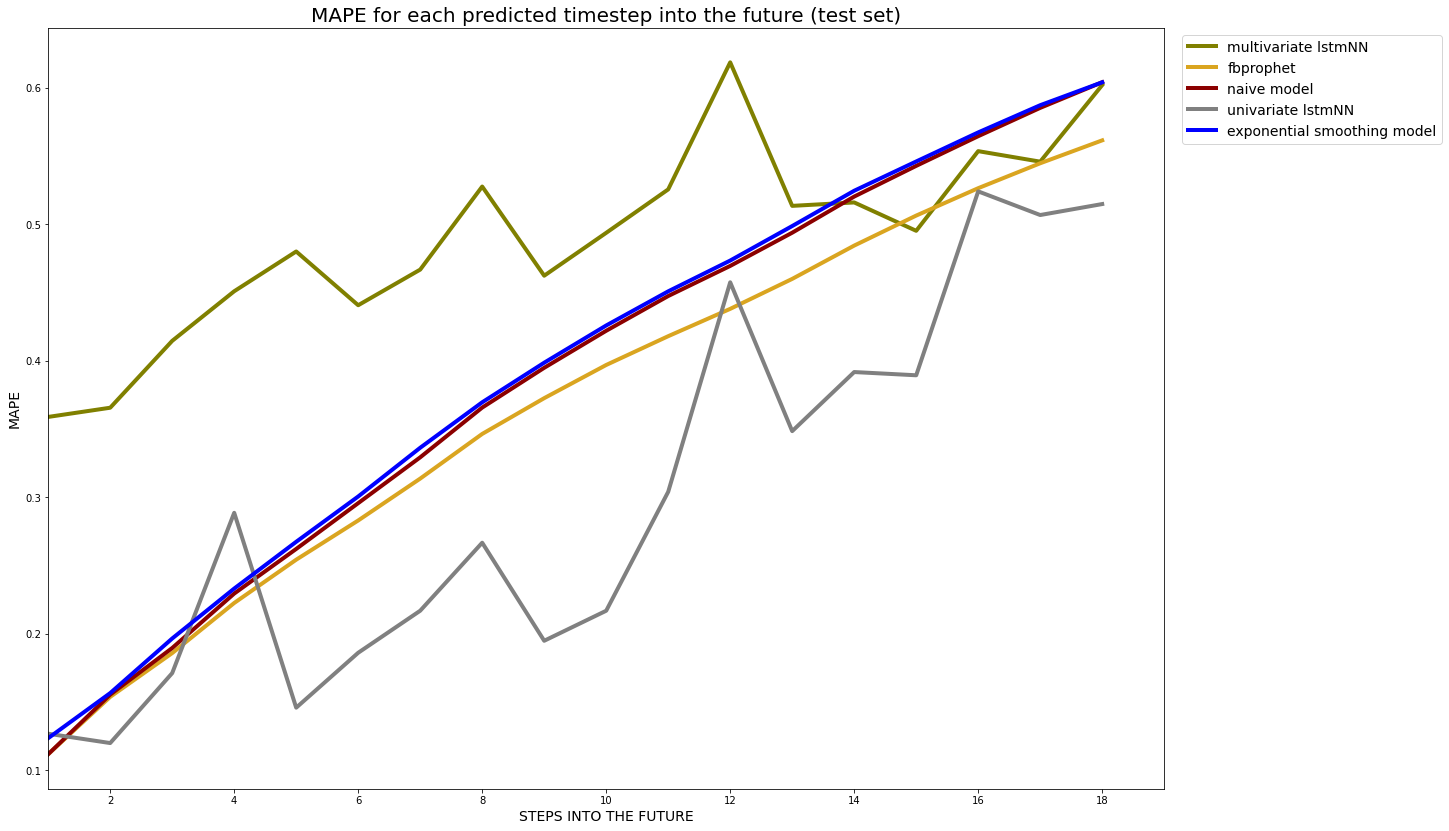

In [8]:
metric ='MAPE'
mape_test = get_erros(metric=metric, folder='Test Errors')
plot_results(mape_test,  metric=metric, val_or_test='test')
mape_test.round(2)

**Observations**: The univariate LSTM is the best performing model for all but for the 1st, 4th and 12th timestep into the future. 

## MAPE Validation Data

Step,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
multivariate lstmNN,0.23,0.34,0.41,0.37,0.42,0.42,0.46,0.45,0.42,0.43,0.54,0.59,0.53,0.58,0.58,0.55,0.61,0.78
exponential smoothing model,0.17,0.22,0.28,0.33,0.38,0.44,0.49,0.54,0.59,0.63,0.67,0.71,0.75,0.80,0.85,0.89,0.93,0.98
naive model,0.15,0.21,0.27,0.32,0.37,0.43,0.48,0.53,0.58,0.62,0.66,0.70,0.75,0.79,0.84,0.88,0.92,0.97
univariate lstmNN,0.16,0.15,0.18,0.32,0.17,0.21,0.24,0.26,0.24,0.24,0.31,0.46,0.39,0.41,0.41,0.53,0.52,0.55
fbprophet,0.15,0.21,0.27,0.32,0.37,0.42,0.47,0.52,0.56,0.60,0.63,0.66,0.70,0.74,0.78,0.81,0.85,0.89


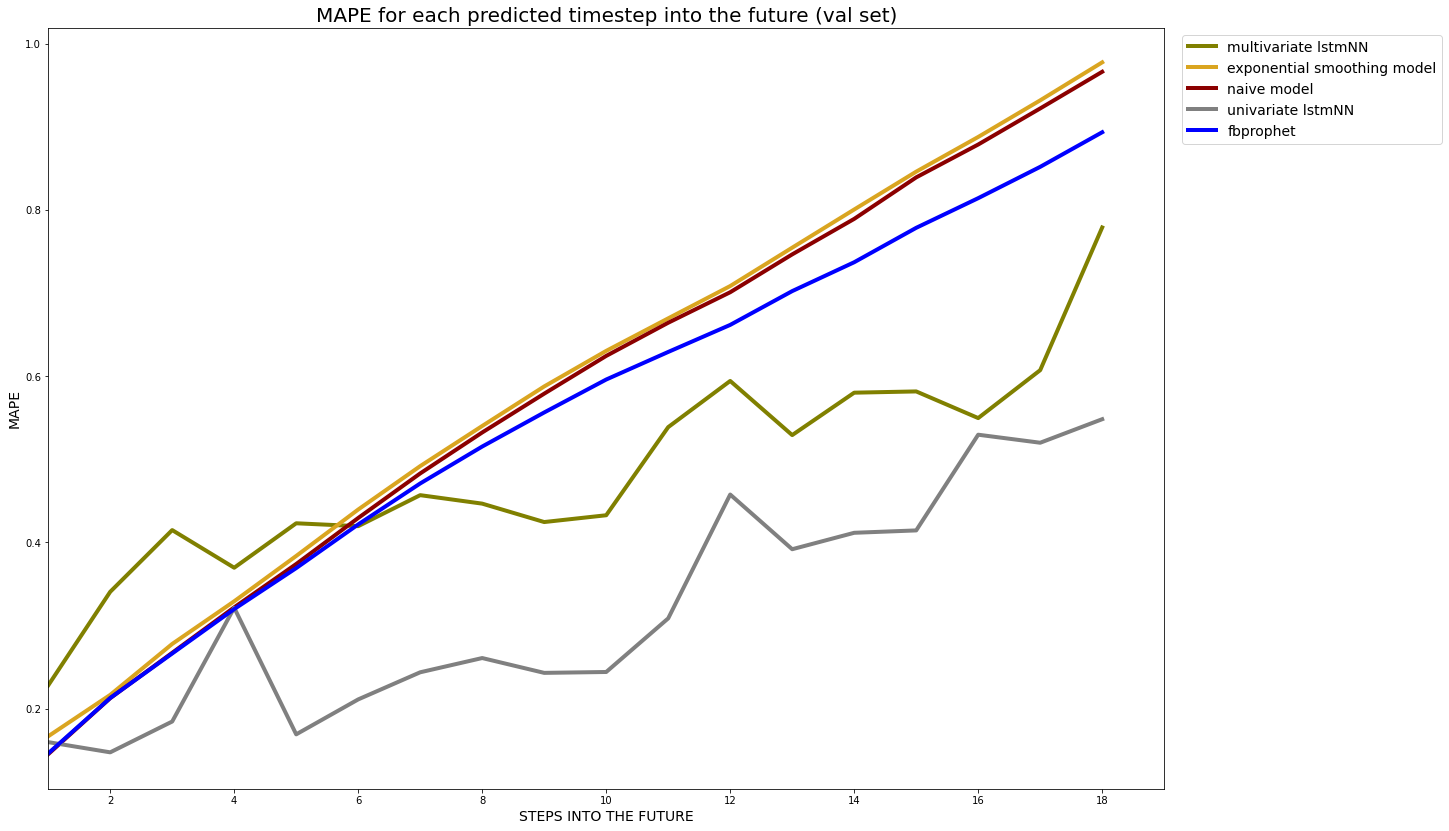

In [9]:
metric = 'MAPE'
mape_val = get_erros(metric = metric, folder='Validation Errors')
plot_results(mape_val, metric = metric, val_or_test='val')
mape_val.round(2)

**Observations**: The univariate LSTM is the best performing model for all but for the 1st timestep into the future. 

## RMSE Validation Data

Step,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
multivariate lstmNN,0.02,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.07,0.05,0.08,0.06,0.06,0.07,0.08,0.07,0.07,0.08
exponential smoothing model,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.06
naive model,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.06
univariate lstmNN,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.04,0.05,0.05,0.05,0.06,0.06,0.06,0.07
fbprophet,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.07,0.07,0.07


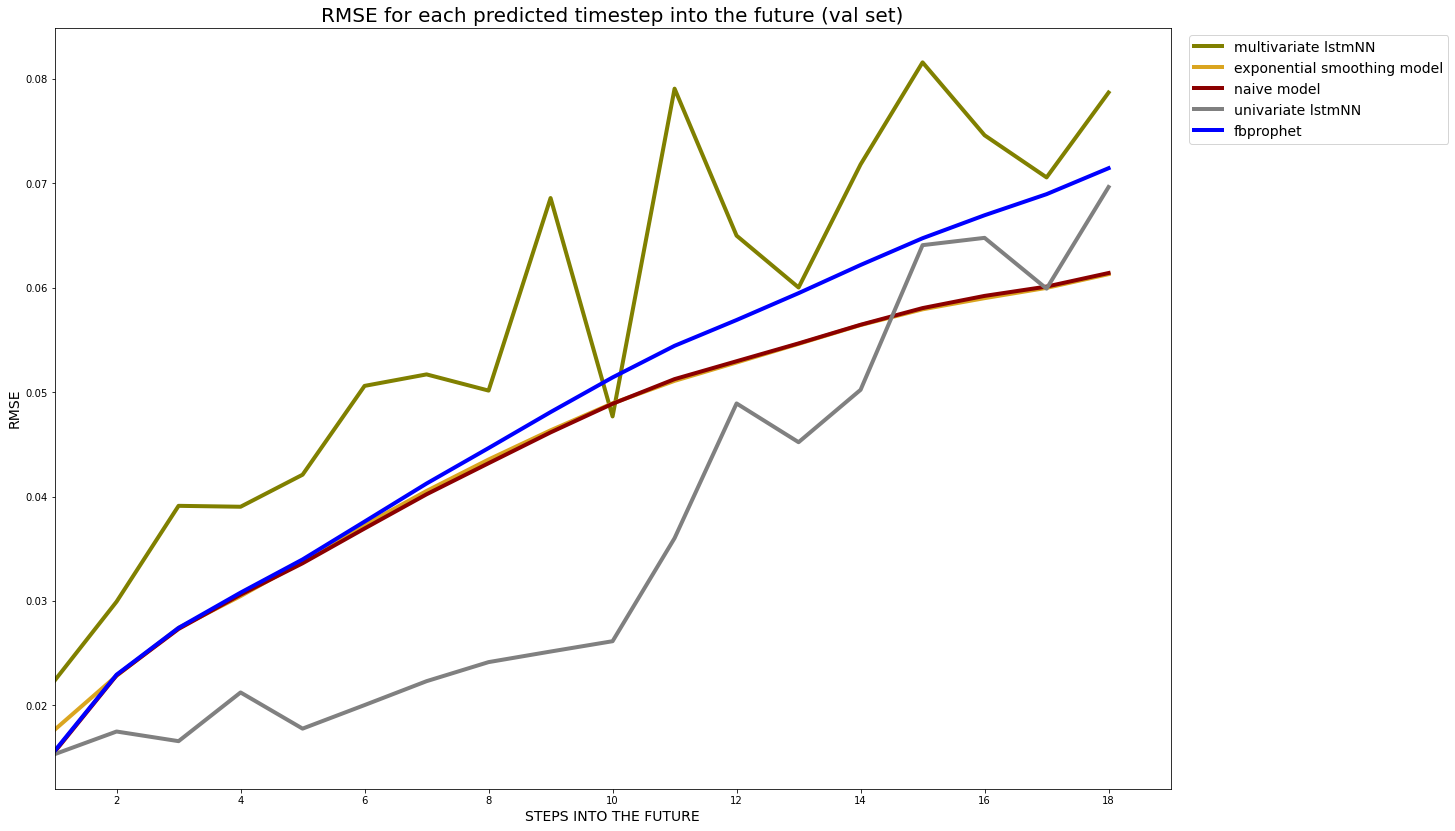

In [11]:
metric = 'RMSE'
mape_val = get_erros(metric = metric, folder='Validation Errors')
plot_results(mape_val, metric = metric, val_or_test='val')
mape_val.round(2)

## RMSE Test Data

Step,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
multivariate lstmNN,0.02,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.07,0.05,0.08,0.06,0.06,0.07,0.08,0.07,0.07,0.08
exponential smoothing model,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.06
naive model,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.06
univariate lstmNN,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.04,0.05,0.05,0.05,0.06,0.06,0.06,0.07
fbprophet,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.06,0.06,0.06,0.06,0.07,0.07,0.07


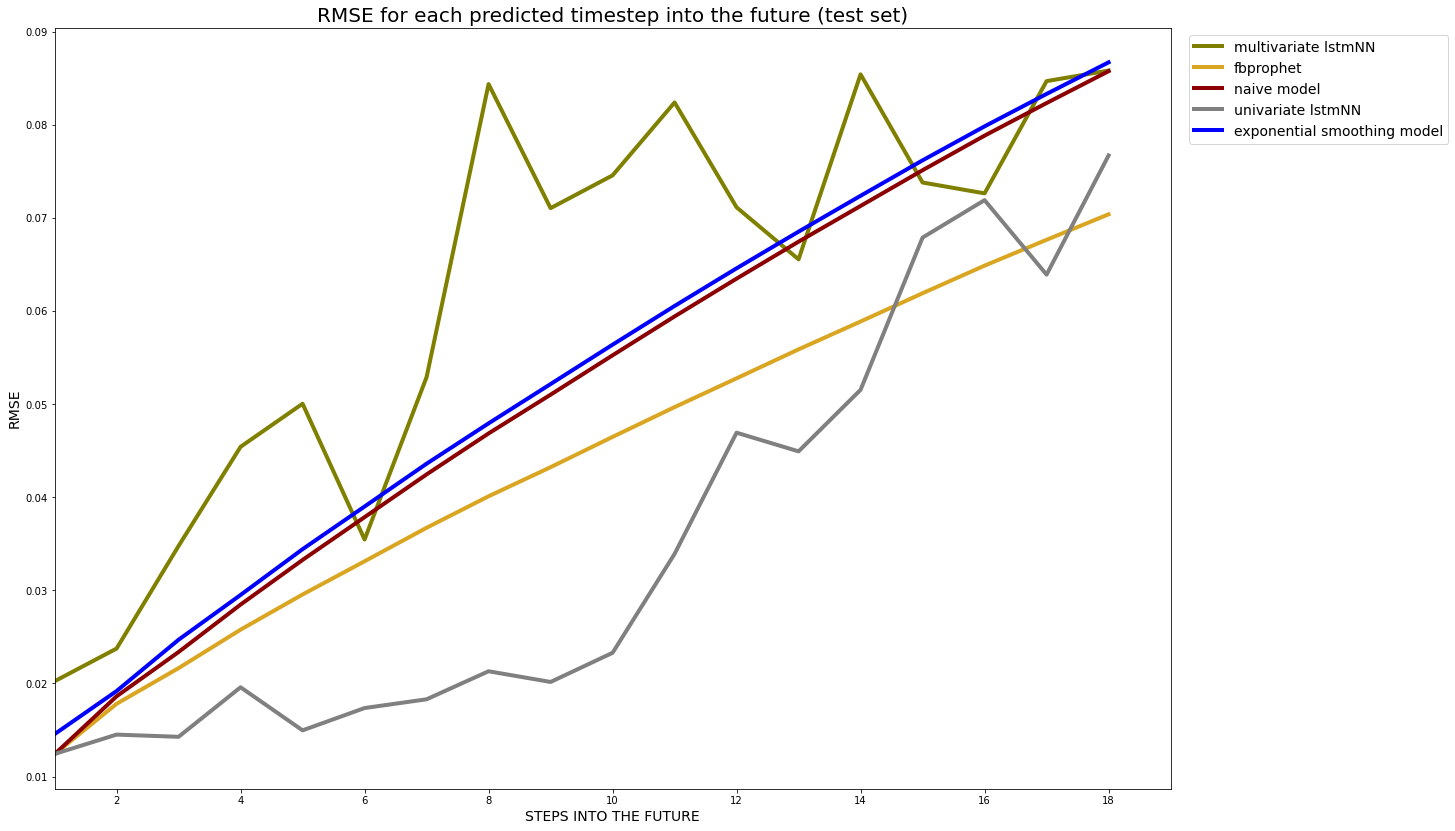

In [12]:
metric = 'RMSE'
mape_test = get_erros(metric = metric, folder='Test Errors')
plot_results(mape_test, metric = metric, val_or_test='test')
mape_val.round(2)

# Future Work

### APIs for live predictions

For live predictions of Feed-In Management loss, GFS Data, Feed-In Management Data as well as Price and Consumption data need to be recieved via an application programming interface (API). 
Services to consider include: 
- [eex Market API](https://www.eex.com/en/market-data/eex-group-datasource/api)
- [SMARD Strommarktdaten](https://www.smard.de/en/downloadcenter/download-market-data)
- [OpenWeather API](https://openweathermap.org/api)
- [climacell Weather Data](https://www.climacell.co/)

### Interpolation of inconsistent / artificial data April/Mai 2019

In the Exploratory Data Analysis, inconsistent / artificial data was observered for part of April/Mai 2019. In the current approach, the data was cut of at `2019-04-30 06:00:00` to avoide the model being trained on artificial data. A interpolation of the data gap could be done using a Standard Week or even a prediction model for the seasonal data. 

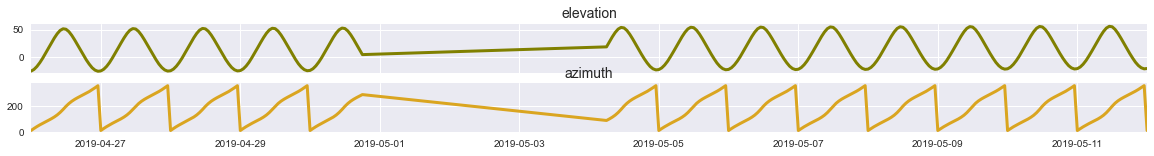

In [35]:
# reading in the feature dataframe
with open('./data/griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df = u.load()
    
#### DATA SELECTION ####
start_index = pd.to_datetime("2019-04-26 00:00:00 +00:00")
end_index = pd.to_datetime("2019-05-12 00:00:00 +00:00")
f_to_plot = ['elevation', 'azimuth']

#reduced timeframe
df_reduced = df[(df.index <= end_index) & (df.index >= start_index)]

#### PLOTTING #####
color=iter(['olive', 'goldenrod', 'darkred', 'sandybrown', 'sienna', 'grey'])
fig, axs = plt.subplots(len(f_to_plot), sharex=True, figsize=(20,len(f_to_plot)*1), facecolor='w')
for f, axes in zip(f_to_plot, axs): 
    c=next(color, 'goldenrod')
    axes.plot(df_reduced[f], color=c, lw=3)
    axes.set_title(f, fontsize=14)
    axes.set_xlim(left=start_index, right=end_index)
plt.show(fig);

### Forecast of GFS Data for Feed-In Mgmt predictions >1 timestep

Currently the implemented models predict the Feed-In Management loss based on actual past timesteps. E.g., for a prediction 18 steps into the future, the model looks at the given data and then does the prediction for "in 18 timesteps". As some of the GFS data, as well as price and consumption data are rather seasonal (e.g., graph above for elevation), a more advanced approach could first predict the GFS, price and consumption data 18 steps into the future and then base a Feed-In Managment loss prediction on these predicted GFS, price and consumption data. There is no certainty regarding the performance of this approach. 

# End Note

This is the final project at the Data Science Bootcamp **[@neuefische](www.neuefische.de)**. This project has been developed in the fall of 2020 by Tjade Appel ([LinkedIn](www.linkedin.com/in/tjade-appel) / [GitHub](https://github.com/tjade27)) and Jonas Jaenicke ([LinkedIn](www.linkedin.com/in/jonasjaenicke) / [GitHub](https://github.com/JonJae)). Please feel free to contact us.  